In [1]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from MAS_Environment import MAS_env
import wandb

In [2]:
# MAX_STEPS = 512
# class GymnasiumEnv(gym.Env):
#     def __init__(self, grid_size=20, obs_size=5, num_agents=8, num_targets=6):
#         super(GymnasiumEnv, self).__init__()

#         self.info_grid_size = grid_size
#         self.obs_size = obs_size
#         self.num_agents = num_agents
#         self.num_targets = num_targets
#         self.info_grid = np.zeros((grid_size, grid_size))
#         self.agent_pos = self.reset_agent_positions()  # Random initial agent positions
#         self.targets = self.generate_targets()
#         self.agent_grid = [np.zeros((grid_size, grid_size)) for _ in range(self.num_agents)]
#         self.action_space = spaces.Discrete(5)  # Five discrete actions: up, down, left, right, stay
#         self.observation_space = spaces.Box(low=0, high=1, shape=(obs_size, obs_size), dtype=np.float32)
#         self.step_counter = 0
#         # self.normalize_info()
#         self.reset()

#     def reset_agent_positions(self):
#         return [(np.random.randint(self.info_grid_size), np.random.randint(self.info_grid_size)) for _ in range(self.num_agents)]

#     def generate_targets(self):
#         return [(np.random.randint(self.info_grid_size), np.random.randint(self.info_grid_size)) for _ in range(self.num_targets)]

#     def generate_gaussians(self):
#         # Reset grid to zero before adding Gaussian distributions
#         self.info_grid = np.zeros((self.info_grid_size, self.info_grid_size))
#         for target_pos in self.targets:
#             mean_x, mean_y = target_pos
#             # Ensure sigma is not too large
#             sigma = np.random.uniform(1, min(self.info_grid_size // 2, 10))
#             x, y = np.meshgrid(np.arange(self.info_grid_size), np.arange(self.info_grid_size))
#             # Calculate the Gaussian distribution
#             gaussian = np.exp(-((x - mean_x)**2 + (y - mean_y)**2) / (2 * sigma**2))
#             # Normalize the Gaussian distribution so that the maximum value is 1
#             gaussian /= gaussian.max()
#             # Add the Gaussian distribution to the grid
#             self.info_grid += gaussian
#         # Normalize the grid values to the range [0, 1]
#         self.info_grid /= self.info_grid.max()

#     def step(self, actions):
#         self.step_counter += 1
#         states = []
#         rewards = [0] * self.num_agents
#         dones = [False] * self.num_agents
#         temp = self.info_grid.copy()

#         if self.step_counter >= MAX_STEPS:  # Define MAX_STEPS as the threshold
#             return states, rewards, [True] * self.num_agents, {} 

#         for agent_id, action in enumerate(actions):
#             x, y = self.agent_pos[agent_id]
#             new_pos = self.update_agent_position(x, y, action)
#             self.agent_pos[agent_id] = new_pos
#             self.update_gaussian(new_pos)  # Update Gaussian distribution after reaching a target
#             if new_pos in self.targets:
#                 rewards[agent_id] = np.sum(temp - self.info_grid)
#                 dones[agent_id] = True
#                 self.targets.remove(new_pos)
#                 self.agent_grid[agent_id][new_pos[0], new_pos[1]] = 1  # Update agent grid at new position

#                 # Share and update agent_grid with other agents if mutual target positions exist
#                 for other_agent_id in range(self.num_agents):
#                     if other_agent_id != agent_id and np.any(self.agent_grid[agent_id] * self.agent_grid[other_agent_id] > 0):
#                         mutual_targets = np.where(self.agent_grid[agent_id] * self.agent_grid[other_agent_id] > 0)
#                         self.agent_grid[other_agent_id][mutual_targets] = 1  # Update mutual target positions

#             self.agent_grid[agent_id] = self.get_agent_views(agent_id)  # Update agent's grid
#             state_1 = self.get_state_1(agent_id)
#             state_2 = self.get_state_2(agent_id)
#             states.append((state_1, state_2))  # Append the state tuple for the agent to states list
#         return states, rewards, dones, {}

#     def update_gaussian(self, new_pos):
#         sigma = 1  # Smaller Gaussian sigma
#         x_min = max(0, new_pos[0]-2)
#         x_max = min(self.info_grid_size, new_pos[0]+3)
#         y_min = max(0, new_pos[1]-2)
#         y_max = min(self.info_grid_size, new_pos[1]+3)
#         x, y = np.meshgrid(np.arange(x_min, x_max), np.arange(y_min, y_max), indexing='ij')
#         smaller_gaussian = np.exp(-((x - new_pos[0])**2 + (y - new_pos[1])**2) / (2 * sigma**2))
#         # print(smaller_gaussian.shape)
#         max_val = np.max(smaller_gaussian)
#         smaller_gaussian /= max_val if max_val > 0 else 1
#         self.info_grid[y_min:y_max, x_min:x_max] = np.clip(self.info_grid[y_min:y_max, x_min:x_max] - (smaller_gaussian.T * 0.8), 0, None) 
#         self.info_grid /= self.info_grid.max()

#     def get_agent_views(self, agent_id):
#         view = np.zeros((self.info_grid_size, self.info_grid_size))  # Adjust size to match info_grid_size
#         x, y = self.agent_pos[agent_id]
#         window = self.info_grid[x - 2:x + 3, y - 2:y + 3]
#         view[x - 2:x + 3, y - 2:y + 3] = window  # Update view with window from info_grid
#         return view

#     def update_agent_position(self, x, y, action):
#         if action == 0:  # Down
#             y = max(0, y - 1)
#         elif action == 1:  # Up
#             y = min(self.info_grid_size - 1, y + 1)
#         elif action == 2:  # Left
#             x = max(0, x - 1)
#         elif action == 3:  # Right
#             x = min(self.info_grid_size - 1, x + 1)
#         return (x, y)
        
#     def get_state_1(self, agent_id):
#         state_1 = np.zeros((self.obs_size, self.obs_size))
#         x, y = self.agent_pos[agent_id]
#         window = self.info_grid[x - 2:x + 3, y - 2:y + 3]
#         state_1[:window.shape[0], :window.shape[1]] = window
#         return state_1

#     def get_state_2(self, agent_id):
#         x, y = self.agent_pos[agent_id]  # Get position of the specified agent
#         rewards_left = len(self.targets)  # Number of targets left is the rewards left
#         return np.array([x, y, self.step_counter, rewards_left])

#     def reset(self):
#         self.agent_pos = self.reset_agent_positions()
#         self.targets = self.generate_targets()
#         self.info_grid = np.zeros((self.info_grid_size, self.info_grid_size))
#         for target in self.targets:
#             self.info_grid[target] = 2  # Mark targets with 2
#         self.generate_gaussians()  # Generate Gaussian distributions around targets
#         for i in range(self.num_agents):
#             self.agent_grid[i] = self.get_agent_views(i)
#         self.step_counter = 0
#         return self.info_grid, self.agent_grid

#     def render(self, mode='human'):
#         plt.figure(figsize=(12, 8))
#         plt.subplot(2, 2, 1)
#         plt.imshow(self.info_grid, cmap='Oranges', origin='lower')
#         plt.colorbar(label='Information Value')
#         plt.title('Main Grid')
#         plt.xlabel('X')
#         plt.ylabel('Y')
#         plt.grid(visible=True, which="major")

#         # Plot targets
#         for target in self.targets:
#             plt.scatter(target[0], target[1], c='r', marker='o', s=20)

#         for agent in self.agent_pos:
#             plt.scatter(agent[0], agent[1], c='b', marker='o', s=20)

#         plt.tight_layout()
#         plt.show()

# env = GymnasiumEnv(grid_size=32, obs_size=5, num_agents=8, num_targets=8)
# grid, agent_views = env.reset()
# env.render()

In [3]:
# actions = [1] * 8  # List of actions
# next_state, rewards, dones, _ = env.step(actions)
# env.render()

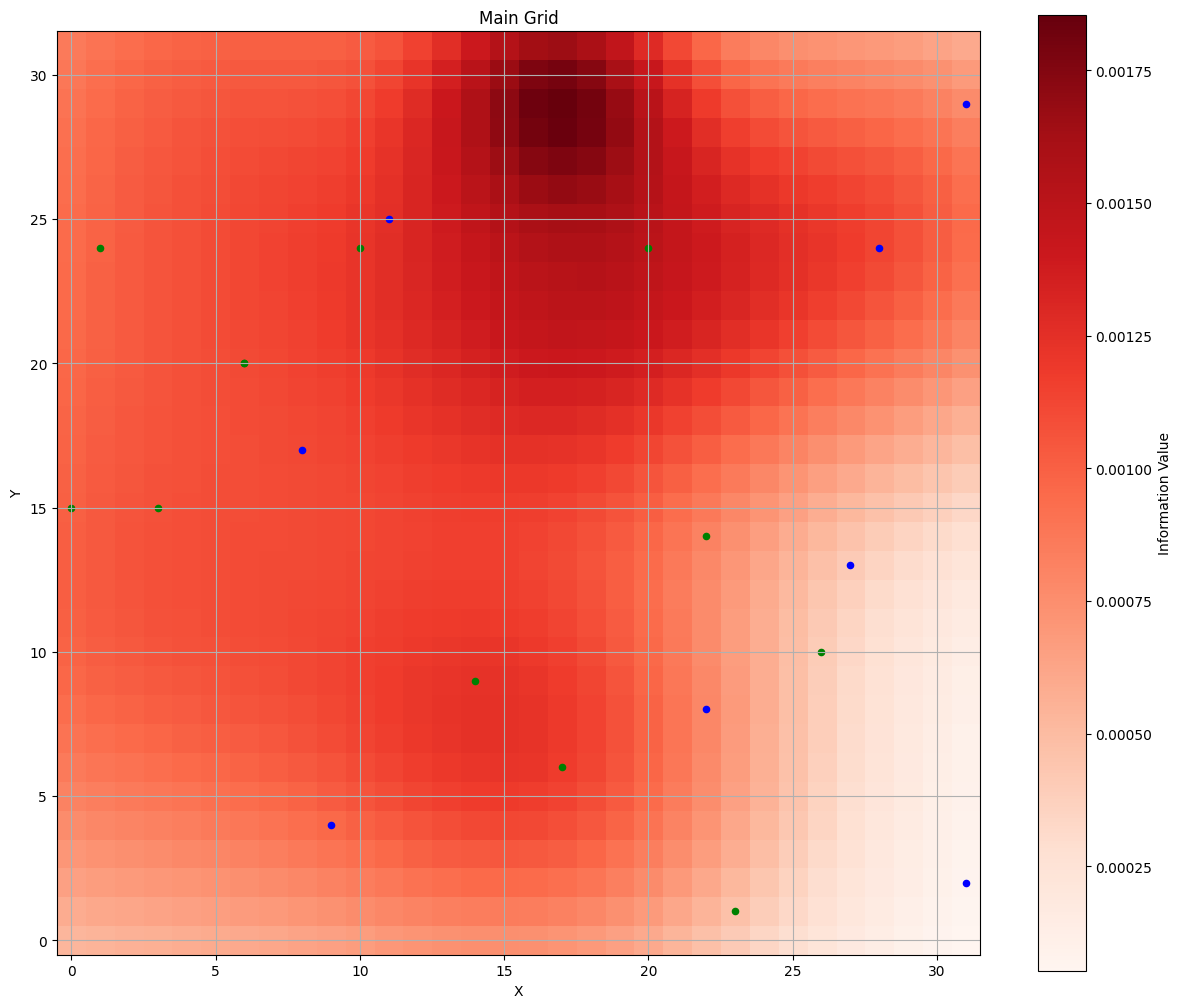

In [4]:
from MAS_Environment import MAS_env

env = MAS_env(grid_size=32,
              obs_size=5,
              num_agents=8,
              num_targets=12)
env.render()


In [ ]:
# import time
# # Demonstration
# for _ in range(5):
#     actions = np.random.randint(0, 5, 8)
#     next_state, rewards, terminated, truncated, _ = env.step(actions)
#     env.render()
#     time.sleep(0.5)
#     # print(np.asarray(rewards)*1000)

ValueError: too many values to unpack (expected 5)

In [6]:
!python MAS.py --asynchronous True

^C



Episodes: 100%|██████████| 10/10 [01:37<00:00,  9.75s/ episodes]

Episodes: 100%|██████████| 10/10 [01:55<00:00, 11.52s/ episodes]

Episodes: 100%|██████████| 10/10 [01:57<00:00, 11.80s/ episodes]

Episodes: 100%|██████████| 10/10 [02:21<00:00, 14.15s/ episodes]

Episodes: 100%|██████████| 10/10 [02:30<00:00, 15.09s/ episodes]

Episodes: 100%|██████████| 10/10 [02:43<00:00, 16.32s/ episodes]

Episodes: 100%|██████████| 10/10 [02:50<00:00, 17.03s/ episodes]

Episodes: 100%|██████████| 10/10 [02:47<00:00, 16.76s/ episodes]

Episodes: 100%|██████████| 10/10 [02:38<00:00, 15.86s/ episodes]

Episodes: 100%|██████████| 10/10 [02:35<00:00, 15.50s/ episodes]

Episodes: 100%|██████████| 10/10 [02:10<00:00, 13.02s/ episodes]

Episodes: 100%|██████████| 10/10 [02:41<00:00, 16.18s/ episodes]

Episodes: 100%|██████████| 10/10 [02:30<00:00, 15.01s/ episodes]

Episodes: 100%|██████████| 10/10 [03:00<00:00, 18.01s/ episodes]

Episodes: 100%|██████████| 10/10 [02:38<00:00, 15.86s/ episodes]

Episodes:

Running A3C with 16 workers
Running A3C with 16 workers
Running A3C with 16 workers
Running A3C with 16 workers
Running A3C with 16 workers
Running A3C with 16 workers
Running A3C with 16 workers
Running A3C with 16 workers
Running A3C with 16 workers
Running A3C with 16 workers
Running A3C with 16 workers
Running A3C with 16 workers
Running A3C with 16 workers
Running A3C with 16 workers
Running A3C with 16 workers
Running A3C with 16 workers
Running A3C with 16 workers
Exit Loop


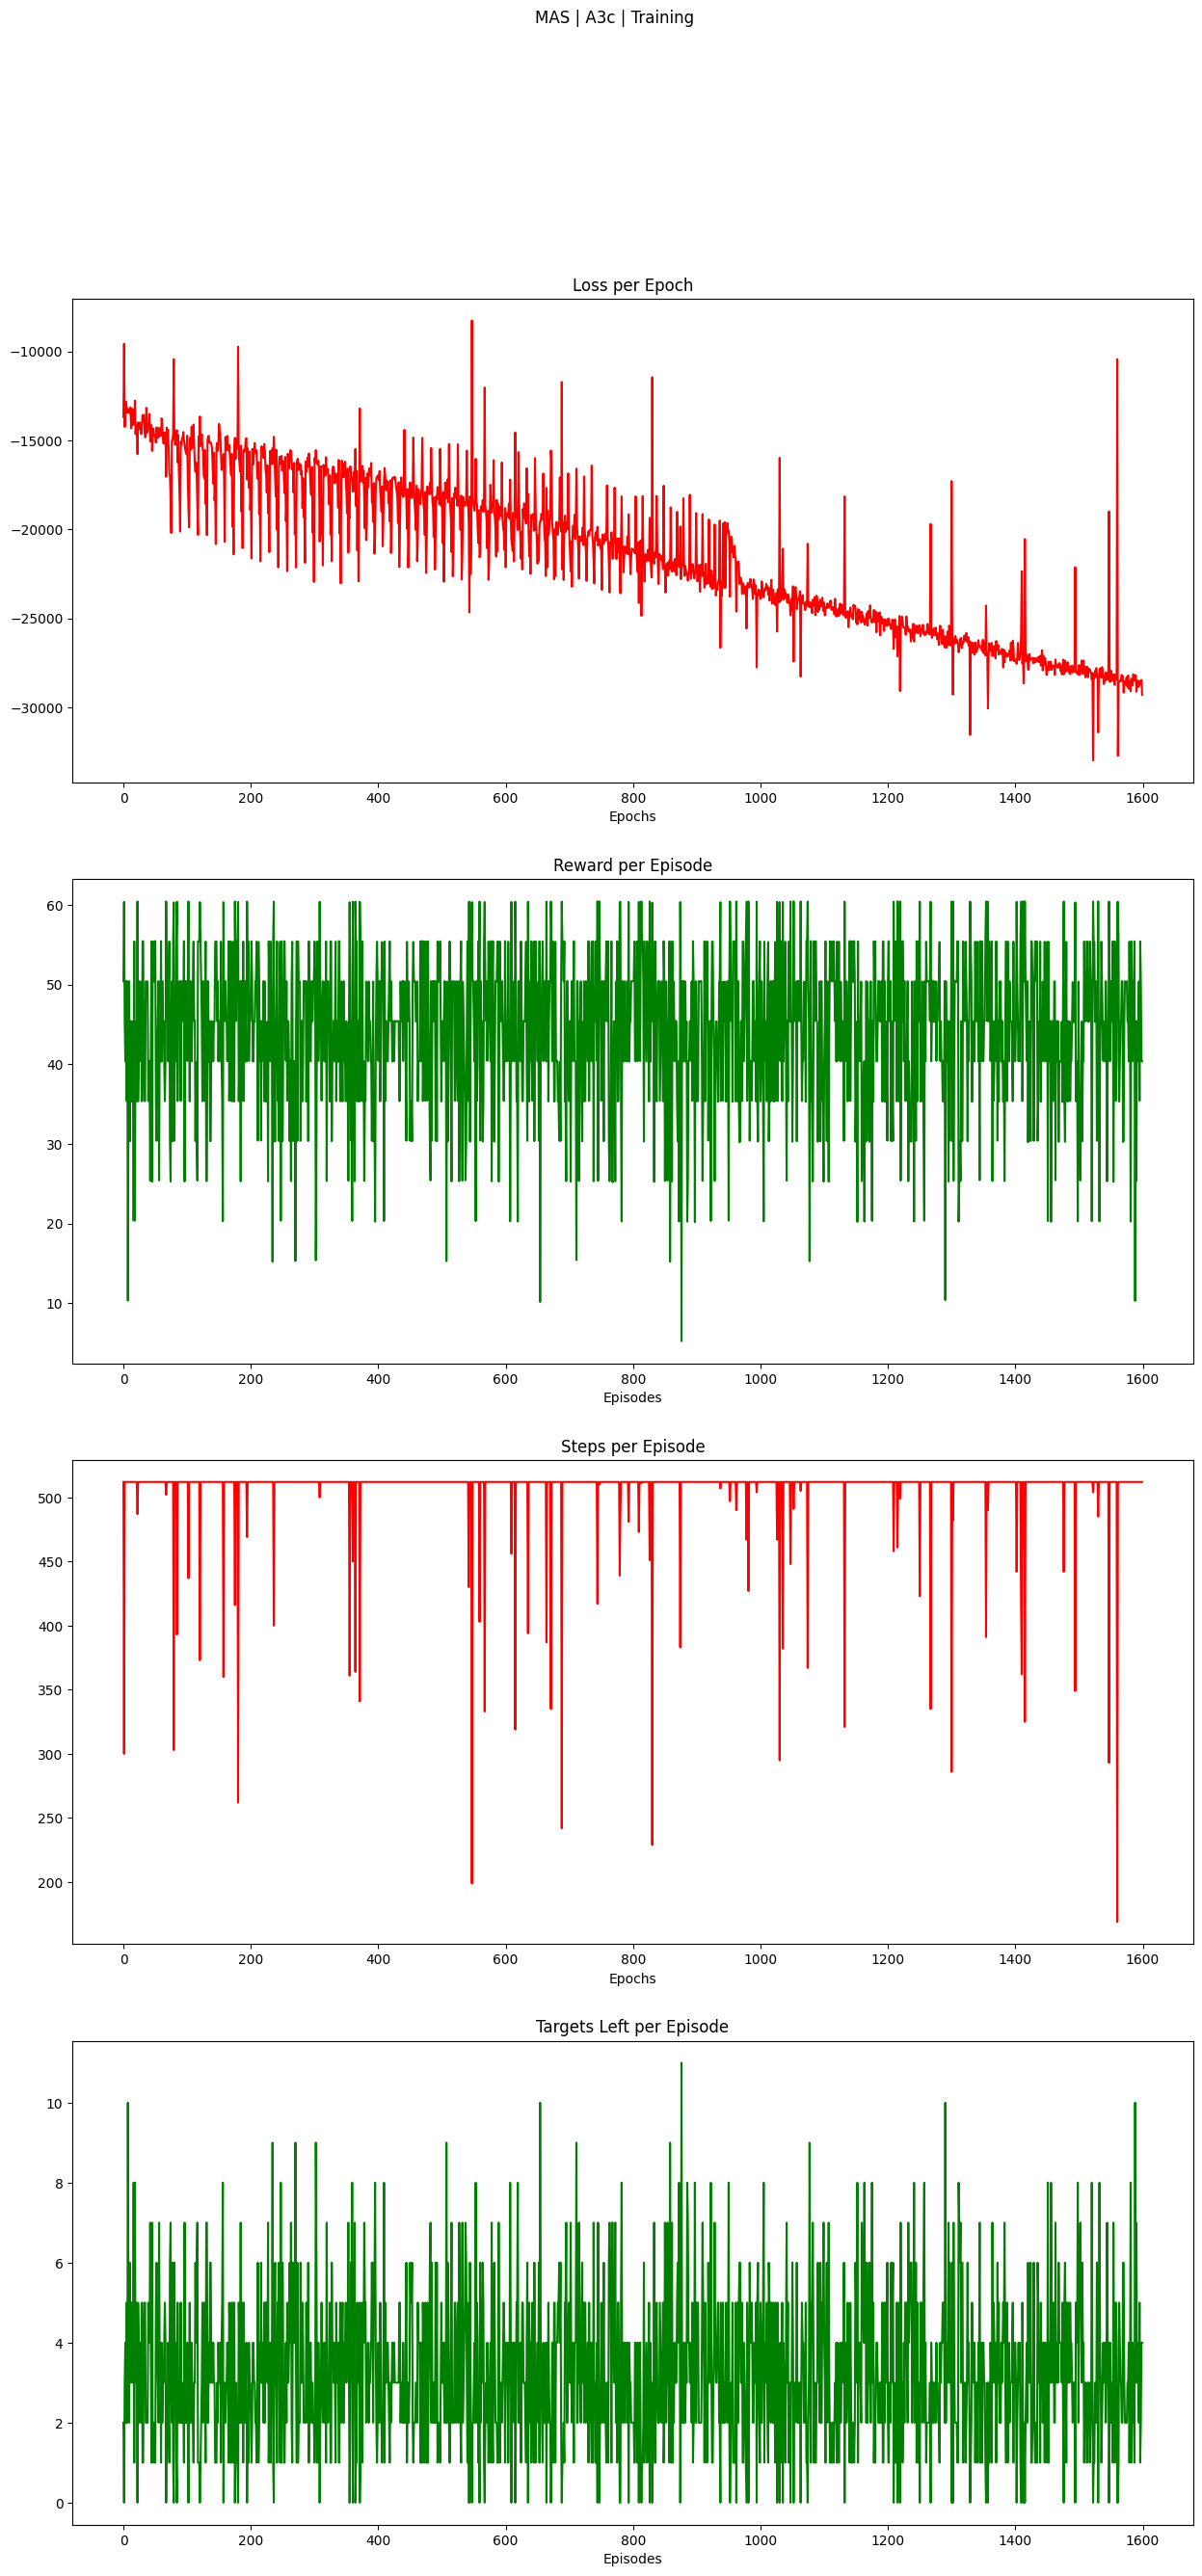

In [11]:
import torch
a3c_mas_losses = torch.load("a3c_mas_losses.pkl")
a3c_mas_reward = torch.load("a3c_mas_rewards.pkl")
a3c_mas_steps = torch.load("a3c_mas_steps.pkl")
a3c_mas_targets = torch.load("a3c_mas_targets.pkl")

plt.figure(figsize=(15, 30))
plt.subplot(411),plt.plot(list(range(len(a3c_mas_losses))), a3c_mas_losses, c="r"),plt.xlabel("Epochs"), plt.title('Loss per Epoch')
plt.subplot(412),plt.plot(list(range(len(a3c_mas_reward))), a3c_mas_reward, c="g"),plt.xlabel("Episodes"), plt.title('Reward per Episode')
plt.subplot(413),plt.plot(list(range(len(a3c_mas_steps))), a3c_mas_steps, c="r"),plt.xlabel("Epochs"), plt.title('Steps per Episode')
plt.subplot(414),plt.plot(list(range(len(a3c_mas_targets))), a3c_mas_targets, c="g"),plt.xlabel("Episodes"), plt.title('Targets Left per Episode')

plt.suptitle("MAS | A3c | Training")
plt.show()

In [2]:
TEST_EPISODES = 1
wandb.init(project="mas-a3c", name="info- surfing")
# wandb.define_metric("step")
wandb.define_metric("loss", step_metric="step")

env = MAS_env(grid_size=24,
              obs_size=5,
              num_agents=8,
              num_targets=12)

episode_steps = []
episode_rewards = []
episode_targets = []

for _ in range(TEST_EPISODES):
    done = False
    state_1, _ = env.reset()

    episode_reward = 0
    episode_step = 0

    while not done:
        actions = []
        for state in state_1:
            d_x = np.gradient(state, axis=0).sum()
            d_y = np.gradient(state, axis=1).sum()

            if abs(d_x) >= abs(d_y):
                if d_x <= 0:
                    actions.append(2)
                else:
                    actions.append(3)
            else:
                if d_y <= 0:
                    actions.append(0)
                else:
                    actions.append(1)
            
        actions = np.asarray(actions)

        next_state_1, _, reward, terminated, truncated, _ = env.step(actions)
        env.render("human")
        episode_step += 1
        episode_reward += reward.sum()

        done = terminated or truncated

        state_1 = next_state_1
    
    episode_steps.append(episode_step)
    episode_rewards.append(episode_reward)
    episode_targets.append(env.targets_left)

    for rewards, steps, targets in zip(episode_rewards, episode_steps, episode_targets):
        log_dict = {
            "reward": rewards,
            "step": steps,
            "target": targets
        }
        # wandb.log({'loss': loss.detach().item()}, step = step_num)
        wandb.log(log_dict)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: venkatakrishnan1241 (venkat1). Use `wandb login --relogin` to force relogin


In [4]:
# import imageio

# # Combine frames into a video
# with imageio.get_writer('rendered_video.mp4', mode='I') as writer:
#     for frame_path in env.file_paths:
#         image = imageio.imread(frame_path+".png")
#         writer.append_data(image)